In [4]:
using DifferentialEquations, Plots, LinearAlgebra, Interact

In [5]:
# Define constants 
eps0 = 8.8541878128e-12;
mu0 = 1.256637062e-6;
c0 = 1/sqrt(eps0*mu0);
imp0 = sqrt(mu0/eps0);
Q_factor = 1e9;
center_wavelength = 1550e-9;
omega0 = 2 * π * c0/center_wavelength;
width = 10e-15;
delay = 4 * width;

This section is just for testing purposes to see how the amplitude of the system changes with a constant drive pump. 

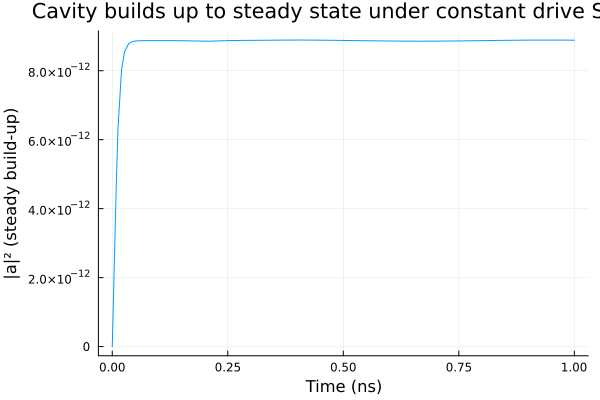

In [6]:
# 1) Envelope‐frame CMT ODE (single mode)
function cmt_envelope!(du, u, p, t)
    Δ, α, γe, γd, S = p
    γ = γe + γd
    du[1] = -(γ + 1im*Δ)*u[1] + 1im*α*abs2(u[1])*u[1] + sqrt(2γe)*S
end

const A_drive = 1.0           # drive amplitude
const ω_drive = 2π*1e12       # drive frequency [rad/s]

# 2) Parameters
ω0         = 2π*1e12    # cavity resonance
ωdrive     = 2π*0.999e12 # drive just below resonance
Δ          = ω0 - ωdrive
α          = 1e3
γe         = 1e11
γd         = 0.5e11
S          = 1.0        # constant envelope drive amplitude
p          = (Δ, α, γe, γd, S)

u0         = ComplexF64[0.0]    # start empty
tspan      = (0.0, 1e-9)        # 2 ns

# 3) Solve
prob       = ODEProblem(cmt_envelope!, u0, tspan, p)
sol        = solve(prob, Tsit5(); reltol=1e-8, abstol=1e-8)

# 4) Plot envelope energy |a|^2 over time
ts   = sol.t .*1e9      # in nanoseconds
a_ts = [u[1] for u in sol.u]

plot(ts, abs2.(a_ts),
     xlabel="Time (ns)",
     ylabel="|a|² (steady build-up)",
     title="Cavity builds up to steady state under constant drive S=$(S)",
     legend=false)


This section will focus on computing the Carrier-wave oscillations in the lab frame. In this frame, the pump is modeled by a Gaussian wavepacket that is introduced to the single mode. This model is only for the single mode case. 

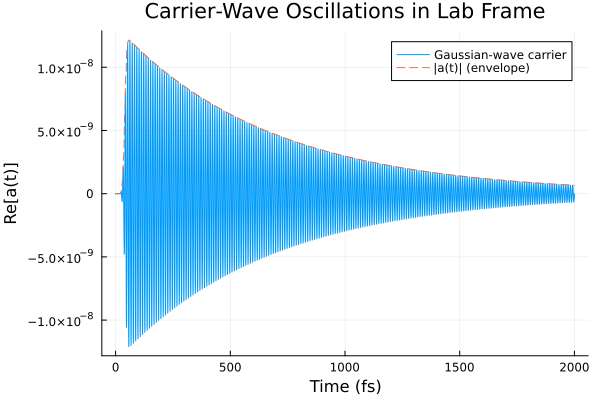

In [7]:
# 1) Full lab‐frame CMT ODE
#    da/dt = [i(ω0 - α|a|^2) - γ] a  + √(2γe) · A_drive·e^{iω_drive t}
function cmt_lab!(du, u, p, t)
    ω0, α, γe, γd, A_drive, ωdrive = p
    γ = γe + γd

    # drive term (fast oscillation):
    drive = A_drive * exp(-((t-delay)/width)^2) * sin(ω0*t)

    du[1] = (1im*(ω0 - α*abs2(u[1])) - γ)*u[1] + sqrt(2γe)*drive
end

# Parameters were just taken from usual inputs in experiments
# 2) Parameters
ω0      = 2π * 1e14      # resonator at 100 THz
ωdrive  = ω0             # on resonance
α       = 1e3
γe      = 1e12           # coupling rate (Hz)
γd      = 0.5e12         # internal loss (Hz)
A_drive = 1.0            # drive amplitude

p = (ω0, α, γe, γd, A_drive, ωdrive)
u0 = ComplexF64[0.0]     # start with no enery in system

# 3) Time‐domain settings: resolve femtoseconds
T_opt   = 2π/ωdrive                  # optical period ~1e-14 s
dt_plot = T_opt/50                   # 20 points per period
t_end   = 200 * T_opt                # run for 200 periods
tspan   = (0.0, t_end)

# 4) Solve with forced max‐step and save-at
prob = ODEProblem(cmt_lab!, u0, tspan, p)
sol  = solve(prob,
             Tsit5(),
             dtmax   = dt_plot,        # never step larger than one period/20
             saveat  = dt_plot,        # record every period/20
             reltol  = 1e-6,
             abstol  = 1e-6)


# 5) Extract and plot
ts   = sol.t .* 1e15   # convert to femtoseconds for readability
a_ts = [u[1] for u in sol.u]

# (a) Real part of a(t): will show the sine‐wave carrier
# plot(ts, real.(a_ts),
#      xlabel = "Time (fs)",
#      ylabel = "Re[a(t)]",
#      title  = "Carrier‐Wave Oscillations in Lab Frame",
#      label = "Sine-wave carrier")

plot(ts, real.(a_ts),
     xlabel = "Time (fs)",
     ylabel = "Re[a(t)]",
     title  = "Carrier‐Wave Oscillations in Lab Frame",
     label = "Gaussian-wave carrier")

# (b) Envelope on top: moving-average or abs.
#    Here we overplot |a| to show its slow envelope
plot!(ts, abs.(a_ts),
      linestyle = :dash,
      label     = "|a(t)| (envelope)")


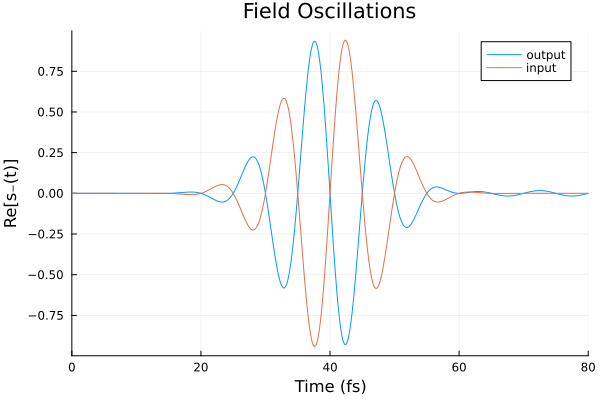

In [8]:
# Output Field:
s_minus = [-A_drive * exp(-((t-delay)/width)^2) * sin(ωdrive*t) + sqrt(2γe)*a for (t,a) in zip(sol.t, a_ts)]
splus = [A_drive * exp(-((t-delay)/width)^2) * sin(ωdrive*t) for (t,a) in zip(sol.t, a_ts)]
plot(ts, real.(s_minus),
     xlabel="Time (fs)",
     ylabel="Re[s₋(t)]",
     title="Field Oscillations",
     label = "output",
     )
plot!(ts, real.(splus), label="input")
xlims!(0,80)

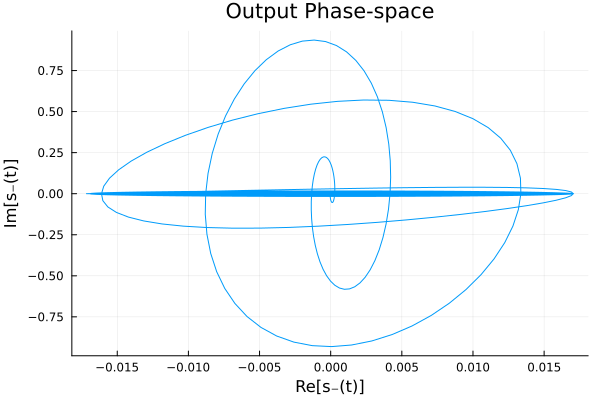

In [9]:
# Phase-space plotted here of the output signal 
plot(imag.(s_minus), real.(s_minus), xlabel="Re[s₋(t)]", ylabel="Im[s₋(t)]", title="Output Phase-space", legend=false)

This section will attempt to solve the Stochastic Differential Equation. We are now including the Langevin stochastic diffusion term and assuming the normalized diffusion term to be the Einstein diffusion relation at room temperature. 

In [33]:
# Defining constants for the Einstein diffusion coefficient
BOLTZM = 1.380649e-23 # Joules/Kelvin
TEMP = 293 # Kelvin
# 2) Parameters
ω0      = 2π * 1e14      # resonator at 100 THz
ωdrive  = ω0             # on resonance
α       = 1e3
γe      = 1e12           # coupling rate (Hz)
γd      = 0.5e12         # internal loss (Hz)
A_drive = 1.0            # drive amplitude

function f(du, u, p, t)
    ω0, α, γ, γd, drive = p 
    drive = A_drive * exp(-((t-delay)/width)^2) * sin(ω0*t)

    du[1] = (1im * (ω0 - α*abs2(u[1]))-γ)*u[1] + sqrt(2*γd) * drive
end

function g(du, u, p, t)
    γ = p[3]
    du[1,1] = BOLTZM*TEMP/γ
end


# Setting up the SDE solver 
u0 = ComplexF64[0.0+0im] #Starting with empty space (no energy)

# 3) Time‐domain settings: resolve femtoseconds
T_opt   = 2π/ωdrive                  # optical period ~1e-14 s
num_p = 1000 # number of periods
t_end   = num_p * T_opt                # run for num_p periods
tspan   = (0.0, t_end)

p = (ω0, α, γe+γd, γd, A_drive)
W = WienerProcess(0.0, zeros(1), Diagonal([1.0]))
prob = SDEProblem(f,g,u0,tspan,p, noise=W)
sol = solve(prob, SRIW1(), dt=0.001, saveat = t_end/100); 

In [34]:
t_end

1.0e-11

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


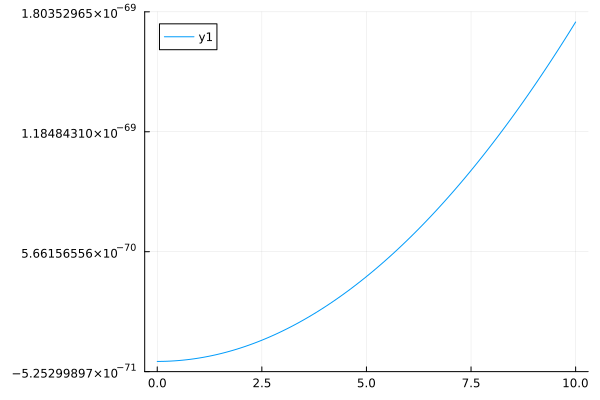

In [35]:
zs = first.(sol.u)
re = real.(zs)
im_sol = imag.(zs)

temp = abs2.(zs)
times = sol.t * 1e12
plot(times, temp)

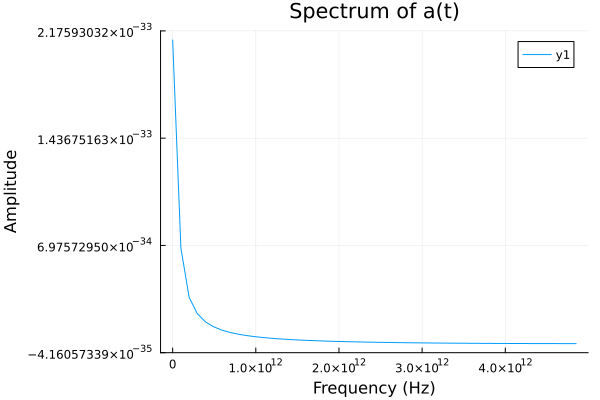

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [36]:
using FFTW
Z = reduce(hcat, sol.u)
ts = sol.t
delta_t = ts[2] - ts[1]
fs = 1/delta_t
M = length(zs)
M2 = fld(M,2)

#Fourier Transform
W = fft(Z)

#Frequencies and one-sided spectrum
freqs = (0:M-1)*(fs/M)
fpos = freqs[1:M2]
Wpos = W[1:M2]

#Plot
plot(fpos, abs.(Wpos), xlabel = "Frequency (Hz)", ylabel="Amplitude", title = "Spectrum of a(t)")

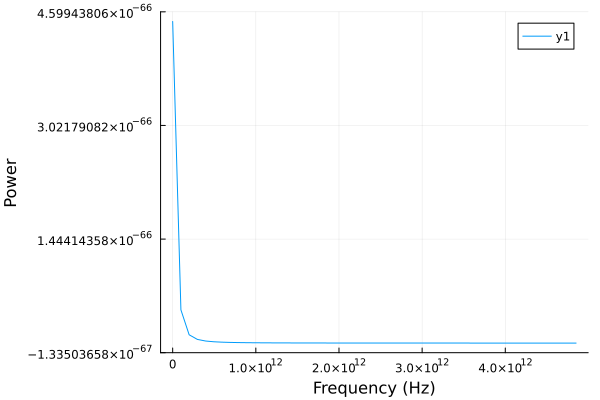

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/princetonwork/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [37]:
plot(fpos, abs.(Wpos).^2, xlabel="Frequency (Hz)", ylabel="Power")